In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy 
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 


import matplotlib.pyplot as plt 
import seaborn as sns

import numpy as np
import pandas as pd

import nltk 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords

import re 

In [2]:
# get the data 
train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
# Dataset size 

print("Examples in train data : {}".format(len(train)))
print("Examples in test data : {}".format(len(test)))

Examples in train data : 41157
Examples in test data : 3798


In [4]:
train.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
dist_train = train['Sentiment'].value_counts()
dist_test = test['Sentiment'].value_counts()

def distribution_plot(x, y, name=""):
    plt.figure(figsize=(15,5))
    sns.barplot(x=x, y=y)
    plt.title(name)
    plt.show()


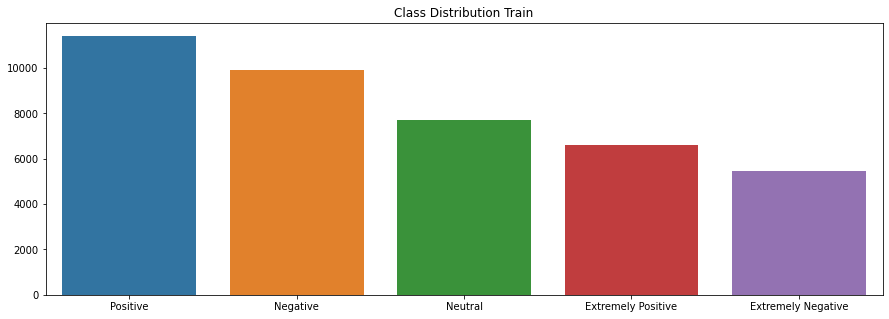

In [8]:
distribution_plot(x=dist_train.index, y=dist_train.values, name="Class Distribution Train")

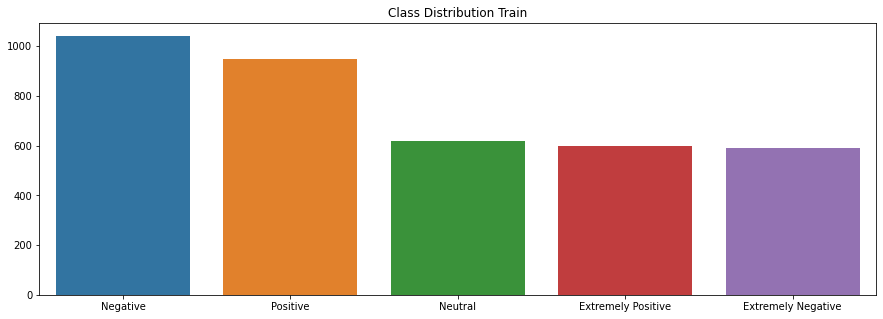

In [9]:
distribution_plot(x=dist_test.index, y=dist_test.values, name="Class Distribution Train")

In [10]:
# DATA PREPROCESSING 

X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

In [14]:
# Cleaning 
nltk.download('stopwords')
stop_words = stopwords.words('english')

def data_cleaner(tweet):
    # remove urls
    tweet = re.sub(r'http\S+', '', tweet)

    # remove html tags 
    tweet = re.sub(r'<.*?>', '', tweet)

    # remove digits
    tweet = re.sub(r'\d+', '', tweet)

    #remove hashtags 
    tweet = re.sub(r'#\w+', '', tweet)

    # remove mentions 
    tweet = re.sub(r'@\w+', '', tweet)

    # removing stop words

    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])

    return tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
data_cleaner("https:\\skdjfh.com is the good website with 900 followers #goood @obama should take a look into it")

'good website followers take look'

In [16]:
X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [18]:
# TOKENIZING 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

vocab_size = len(tokenizer.word_index)+1


print("Vocabulary size {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[10]))
print("\nAfter tokenizing :\n{}".format(X[10]))

X = pad_sequences(X, padding='post')
print("\nAfter padding: \n{}".format(X[10]))

Vocabulary size 35935

Example:

Sentence:
All month crowding supermarkets restaurants, however reducing hours closing malls means everyone using entrance dependent single supermarket.

After tokenizing :
[119, 371, 3797, 178, 406, 802, 1611, 194, 614, 2139, 498, 77, 272, 2895, 4678, 718, 6]

After padding: 
[ 119  371 3797  178  406  802 1611  194  614 2139  498   77  272 2895
 4678  718    6    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [19]:
encoding = {
    'Extremely Negative':0,
    'Negative':0,
    'Neutral':1,
    'Positive':2,
    'Extremely Positive':2
}

labels = ['Negative', 'Neutral', 'Positive']

y.replace(encoding, inplace=True)

In [24]:
#Modeling Building & Training 

tf.keras.backend.clear_session()

# hyper parameters 
EPOCHS = 2 
BATCH_SIZE = 32 
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
        L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
        L.Bidirectional(L.LSTM(units, return_sequences=True)),
        L.GlobalMaxPooling1D(),
        L.Dropout(0.4),
        L.Dense(64, activation='relu'),
        L.Dropout(0.4),
        L.Dense(3)


])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 16)            574960    
_________________________________________________________________
bidirectional (Bidirectional (None, 54, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [25]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 54, 16)            574960    
_________________________________________________________________
bidirectional (Bidirectional (None, 54, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [26]:
training_history = model.fit(X, y, epochs=EPOCHS, validation_split=0.12,
                             batch_size=BATCH_SIZE)

Epoch 1/2
1132/1132 [==============================] - 406s 355ms/step - loss: 0.8407 - accuracy: 0.5814 - val_loss: 0.4073 - val_accuracy: 0.8662
Epoch 2/2
1132/1132 [==============================] - 405s 358ms/step - loss: 0.3434 - accuracy: 0.8899 - val_loss: 0.3798 - val_accuracy: 0.8629


In [27]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

X_test = X_test.apply(data_cleaner)

X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post')

y_test.replace(encoding, inplace=True)

In [28]:
pred = model.predict_classes(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [29]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.42728954553604126
Test Accuracy: 0.8464981317520142


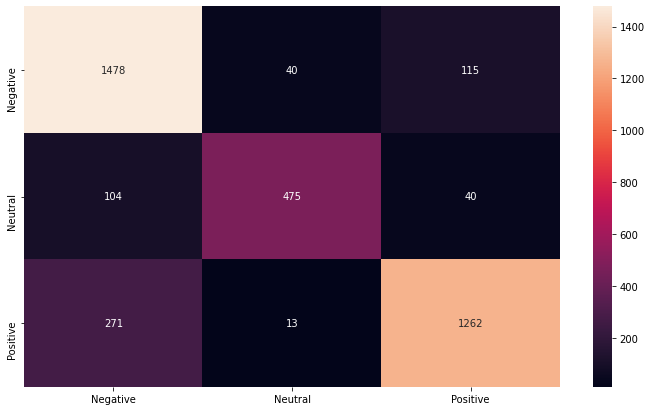

              precision    recall  f1-score   support

    Negative       0.80      0.91      0.85      1633
     Neutral       0.90      0.77      0.83       619
    Positive       0.89      0.82      0.85      1546

    accuracy                           0.85      3798
   macro avg       0.86      0.83      0.84      3798
weighted avg       0.85      0.85      0.85      3798



In [30]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(classification_report(y_test, pred, target_names=labels))
